In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
# sys.path.append("/home/jovyan/pschizhov/ODE_for_Neural_Optimal_Transport")
sys.path.append("..")


ADJOINT = False
SOLVER_METHOD = 'euler'
SOLVER_TS = 10
TOL = 1e-4

DEVICE_IDS = [0]

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 32

BATCH_SIZE = 64


# COST = 'mse' # Mean Squared Error
COST = 'dynamic_ot'
PLOT_INTERVAL = 100
CPKT_INTERVAL = 500
MAX_STEPS = 100001
SEED = 0x000000

DATASET1, DATASET1_PATH = 'handbag', '../../../../data_chizhov/handbag_64.hdf5'
DATASET2, DATASET2_PATH = 'shoes', '../../../../data_chizhov/shoes_64.hdf5'

OUTPUT_PATH = 'checkpoints/{}/{}_{}_steps{}_{}_{}/'.format(COST, SOLVER_METHOD, SOLVER_TS, DATASET1, DATASET2, IMG_SIZE)

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torchdyn.core import NeuralODE
import functorch
import einops
import wandb

assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)
torch.cuda.is_available()

import os, sys
import time
from tqdm import tqdm
import gc

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from models.models import Unet
from models.ode import ODEBlock2
from models.simple_mlp import SimpleSequential, SimpleSequentialTimed

from src_not.resnet2 import ResNet_D
from src_not.tools import unfreeze, freeze
from src_not import distributions
from src_not.tools import weights_init_D
from src_not.tools import load_dataset, get_pushed_loader_stats
from src_not.fid_score import calculate_frechet_distance
from src_not.plotters import plot_random_images, plot_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb # <--- online logging of the results
from src_not.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

In [4]:
#loading stats for FID
filename = '../stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data_y, sigma_data_y = data_stats['mu'], data_stats['sigma']
del data_stats
filename = '../stats/{}_{}_test.json'.format(DATASET1, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data_x, sigma_data_x = data_stats['mu'], data_stats['sigma']
del data_stats

In [5]:
X_train_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH, img_size=IMG_SIZE)
Y_train_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE)
    
torch.cuda.empty_cache(); gc.collect()

Keys: <KeysViewHDF5 ['imgs']>
Keys: <KeysViewHDF5 ['imgs']>


4

In [6]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_train_fixed = X_train_sampler.sample(10)
Y_train_fixed = Y_train_sampler.sample(10)
X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

In [7]:
ode_f = Unet(IMG_SIZE).cuda()
T = ODEBlock2(ode_f,
              t_eval=torch.linspace(0,1,SOLVER_TS).float(),
             sensitivity='adjoint' if ADJOINT else'autograd',
              method=SOLVER_METHOD).cuda()

f = ResNet_D(IMG_SIZE, nc=3, nfilter=64, nfilter_max=256).cuda()

In [8]:
# import pdb
# pdb.pm()

In [9]:
T(torch.randn((10, 3, 32, 32)).cuda())[1]

/home/user/conda/lib/python3.7/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


tensor(0.1382, device='cuda:0', grad_fn=<MeanBackward0>)

In [10]:
class Last_T(nn.Module):
    def __init__(self, T):
        super(Last_T, self).__init__()
        self.T = T
    def forward(self, x):
        res = self.T(x)
        return res[0]
# viz_t = Last_T(T)    

In [11]:
# fig, axes = plot_images(X_fixed, Y_fixed, viz_t)
# fig, axes = plot_random_images(X_sampler, Y_sampler, viz_t)
# fig, axes = plot_images(X_test_fixed, Y_test_fixed, viz_t)
# fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, viz_t)

0. 8 Гауссиан в moon dataset
1. 5 шагов эйлера, без adjointa -> потому что не честно решаем ОДУ -> чтобы показать, разрешение 32, fid раз в 1000 шагов (должен быть убывающим). Это скорее всего будет работать за адекватное время, но проблема с возвращением назад, для этого добавляем регуляризатор со случайной точкой на траекториии в [0, 1] -> есть шанс, возможно можно будет обратить.



In [12]:
# def plot_trajectories(generator, sampler_x, sampler_y, num_steps=25, backward=False):
#     global X_test_fixed, Y_test_fixed
#     with torch.no_grad():          
#         int_time = generator.integration_time
#         new_int_time = torch.linspace(0, 1, num_steps)
#         if backward:
#             new_int_time = torch.linspace(0, 1, num_steps).flip(dims=(0,))
#             X_test_fixed, Y_test_fixed = Y_test_fixed, X_test_fixed
            
#         generator.integration_time = new_int_time
#         T_X_test_fixed, _ = generator(torch.tensor(X_test_fixed, device='cuda'), return_trajectory=False)
#         T_X_test_fixed = T_X_test_fixed.detach().cpu()
#         arr_vis = torch.stack((X_test_fixed, T_X_test_fixed, Y_test_fixed), dim=0)
#         print('Mnist images X, mapped images T(X), unpaired USPS images Y')
#         fig, axes = plot_images3(arr_vis)
        
#         generator.integration_time = int_time
#         if backward:
#             X_test_fixed, Y_test_fixed = Y_test_fixed, X_test_fixed
       

#     return fig, axes


def plot_trajectories(generator,
                      batch_size,
                      X_train_sampler,
                      Y_train_sampler,
                      X_test_sampler,
                      Y_test_sampler,
                      num_steps=25,
                      backward=False):
    
    global X_test_fixed, Y_test_fixed, X_train_fixed, Y_train_fixed
    
    with torch.no_grad():          
        int_time = generator.integration_time
        new_int_time = torch.linspace(0, 1, num_steps)
        if backward:
            new_int_time = torch.linspace(0, 1, num_steps).flip(dims=(0,))
            X_test_fixed, Y_test_fixed = Y_test_fixed, X_test_fixed
            X_train_fixed, Y_train_fixed = Y_train_fixed, X_train_fixed
            
        generator.integration_time = new_int_time 
       
        plot_time = min(num_steps, 10)
        step_time = max(plot_time // 10, 1)
        batch_size = min(batch_size, 10)
        
        # Test fixed
        fig1, axes1 = plt.subplots(plot_time + 1, batch_size, figsize=(plot_time + 1, batch_size), dpi=100)
        _, traj_test_fixed, _ = generator(torch.tensor(X_test_fixed[:batch_size], device='cuda'), return_trajectory=True)
        traj_test_fixed = traj_test_fixed.detach().cpu()
        for i in range(0, plot_time + 1, step_time):
            for j in range(batch_size):
                if i != plot_time:
                    axes1[i][j].imshow(traj_test_fixed[i, j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
                    axes1[i][j].set_xticks([]); axes1[i][j].set_yticks([])
                else:
                    axes1[i][j].imshow(Y_test_fixed[j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0).detach().cpu())
                    axes1[i][j].set_xticks([]); axes1[i][j].set_yticks([])
            fig1.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.95])
        if backward:
            fig1.suptitle('Backward fixed test')
        else:
            fig1.suptitle('Fixed test')
        
        # train fixed
        fig2, axes2 = plt.subplots(plot_time+1, batch_size, figsize=(plot_time+1, batch_size), dpi=100)
        _, traj_train_fixed, _ = generator(torch.tensor(X_train_fixed[:batch_size], device='cuda'), return_trajectory=True)
        traj_train_fixed = traj_train_fixed.detach().cpu()
        for i in range(0, plot_time+1, step_time):
            for j in range(batch_size):
                if i != plot_time:
                    axes2[i][j].imshow(traj_train_fixed[i, j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
                    axes2[i][j].set_xticks([]); axes2[i][j].set_yticks([])
                else:
                    axes2[i][j].imshow(Y_train_fixed[j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0).detach().cpu())
                    axes2[i][j].set_xticks([]); axes2[i][j].set_yticks([])
            fig2.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.95])
        if backward:
            fig2.suptitle('Backward fixed train')
        else:
            fig2.suptitle('Fixed train')
        
           
        if backward:
            X_test, Y_test = Y_test_sampler(batch_size), X_test_sampler(batch_size)
        else:
            X_test, Y_test = X_test_sampler(batch_size), Y_test_sampler(batch_size)
            
        fig3, axes3 = plt.subplots(plot_time + 1, batch_size, figsize=(plot_time +1, batch_size), dpi=100)
        _, traj_test, _ = generator(torch.tensor(X_test, device='cuda'), return_trajectory=True)
        traj_test = traj_test.detach().cpu()
        for i in range(0, plot_time + 1, step_time):
            for j in range(batch_size):
                if i != plot_time:
                    axes3[i][j].imshow(traj_test[i, j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
                    axes3[i][j].set_xticks([]); axes3[i][j].set_yticks([])
                else:
                    axes3[i][j].imshow(Y_test[j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0).detach().cpu())
                    axes3[i][j].set_xticks([]); axes3[i][j].set_yticks([])
            fig3.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.95])
        if backward:
            fig3.suptitle('Backward test')
        else:
            fig3.suptitle('Test') 
        
        
            
        if backward:
            X_train, Y_train = Y_train_sampler(batch_size), X_train_sampler(batch_size)
        else:
            X_train, Y_train = X_train_sampler(batch_size), Y_train_sampler(batch_size)
            
        fig4, axes4 = plt.subplots(plot_time + 1, batch_size, figsize=(plot_time + 1, batch_size), dpi=100)
        _, traj_train, _ = generator(torch.tensor(X_train, device='cuda'), return_trajectory=True)
        traj_train = traj_train.detach().cpu()
        for i in range(0, plot_time + 1, step_time):
            for j in range(batch_size):
                if i != plot_time:
                    axes4[i][j].imshow(traj_train[i, j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
                    axes4[i][j].set_xticks([]); axes4[i][j].set_yticks([])
                else:
                    axes4[i][j].imshow(Y_train[j].mul(0.5).add(0.5).clip(0,1).permute(1,2,0).detach().cpu())
                    axes4[i][j].set_xticks([]); axes4[i][j].set_yticks([])
            fig4.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.95])
        if backward:
            fig4.suptitle('Backward train')
        else:
            fig4.suptitle('Train')
        
        
        
        generator.integration_time = int_time
        if backward:
            X_test_fixed, Y_test_fixed = Y_test_fixed, X_test_fixed
            X_train_fixed, Y_train_fixed = Y_train_fixed, X_train_fixed
       

    return (fig1, fig2, fig3, fig4), (axes1, axes2, axes3, axes4)    
    

In [13]:
# pdb.pm()

In [14]:
# X_test_sampler.sample

In [15]:
# X_train_sampler.sample

In [16]:
# plot_trajectories(T,
#                   BATCH_SIZE,
#                   X_train_sampler.sample,
#                   Y_train_sampler.sample,
#                   X_test_sampler.sample,
#                   Y_test_sampler.sample,
#                   num_steps=10,
#                   backward=False)

In [17]:
# PLOT_INTERVAL = 1
# CPKT_INTERVAL = 1
PLOT_INTERVAL = 100
CPKT_INTERVAL = 500
def train_loop(T, f, X_sampler, Y_sampler, BATCH_SIZE, T_ITERS=10, MAX_STEPS=100001, regularized=True):
    global Y_test_sampler, X_test_sampler
    wandb.init(project='ode_strong_not', name=f'dynamic_ot_euler10step_shoe_bag') 
    # OUTPUT_PATH = f'checkpoints/dynamic_ot_euler10step_shoe_bag'
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    T_LR = 1e-4
    f_LR = 1e-4
    
    T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
    f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)
    
    for step in tqdm(range(MAX_STEPS)):
        # T optimization
        unfreeze(T); freeze(f)
        avg_gen_opt_step_time = 0
        avg_num_func_eval_per_opt_step = 0
        for t_iter in range(T_ITERS):

            generator_opt_step_time = time.time()
            T_opt.zero_grad()
            X = X_sampler(BATCH_SIZE).cuda()

            t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
            T_X = trajectories[-1]

            # total_loss
            if COST == 'mse':
                T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean() + reg_loss      
            elif COST == 'dynamic_ot':
                T_loss = reg_loss - f(T_X).mean() 
            else:
                raise Exception('Unknown COST')

            with torch.no_grad():
                num_func_eval = T.nfe
            T_loss.backward(); T_opt.step()
            with torch.no_grad():
                num_func_eval_per_opt_step = T.nfe - num_func_eval

            generator_opt_step_time = time.time() - generator_opt_step_time
            avg_gen_opt_step_time += generator_opt_step_time
            avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

        avg_gen_opt_step_time /= T_ITERS 
        avg_num_func_eval_per_opt_step /= T_ITERS
        # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()
        
        # f optimization
        freeze(T); unfreeze(f)
        discriminator_opt_step_time = time.time()
        X = X_sampler(BATCH_SIZE).cuda()
        with torch.no_grad():
            T_X, _ = T(X)
        Y = Y_sampler(BATCH_SIZE).cuda()
        f_opt.zero_grad()
        f_loss = f(T_X).mean() - f(Y).mean()
        f_loss.backward(); f_opt.step();
        discriminator_opt_step_time = time.time() - discriminator_opt_step_time
        wandb.log({'f_loss' : f_loss.item(),
                   'T_loss' : T_loss.item(),
                   'reg_loss' : reg_loss.item(),
                  'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
                  'avg_gen_opt_step_time' : avg_gen_opt_step_time,
                  'discriminator_opt_step_time' : discriminator_opt_step_time
                  }, step=step) 

        if step % PLOT_INTERVAL == 0:
            print('Plotting')
            # clear_output(wait=True)
            
            figs, axes = plot_trajectories(T,
                              BATCH_SIZE,
                              X_sampler,
                              Y_sampler,
                              X_test_sampler.sample,
                              Y_test_sampler.sample,
                              num_steps=10,
                              backward=False)

            wandb.log({'Fixed Images' : [wandb.Image(fig) for fig in figs]}, step=step) 
            [plt.show(fig) for fig in figs]; [plt.close(fig) for fig in figs] 

        if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:
            
            freeze(T); 

            print('Computing FID')

            # mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader)
            # fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
            mu, sigma = get_pushed_loader_stats(Last_T(T), X_test_sampler.loader, batch_size=BATCH_SIZE, verbose=True)
            fid = calculate_frechet_distance(mu_data_y, sigma_data_y, mu, sigma)
            wandb.log({f'FID (Test)' : fid}, step=step)
            # del mu, sigma
            torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
            torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
            torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
            torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))    


/home/user/conda/lib/python3.7/site-packages/notebook/utils.py:282: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Currently logged in as: peter_chizhov. Use `wandb login --relogin` to force relogin


/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/100001 [00:00<?, ?it/s]

/home/user/conda/lib/python3.7/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


Plotting


/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().de

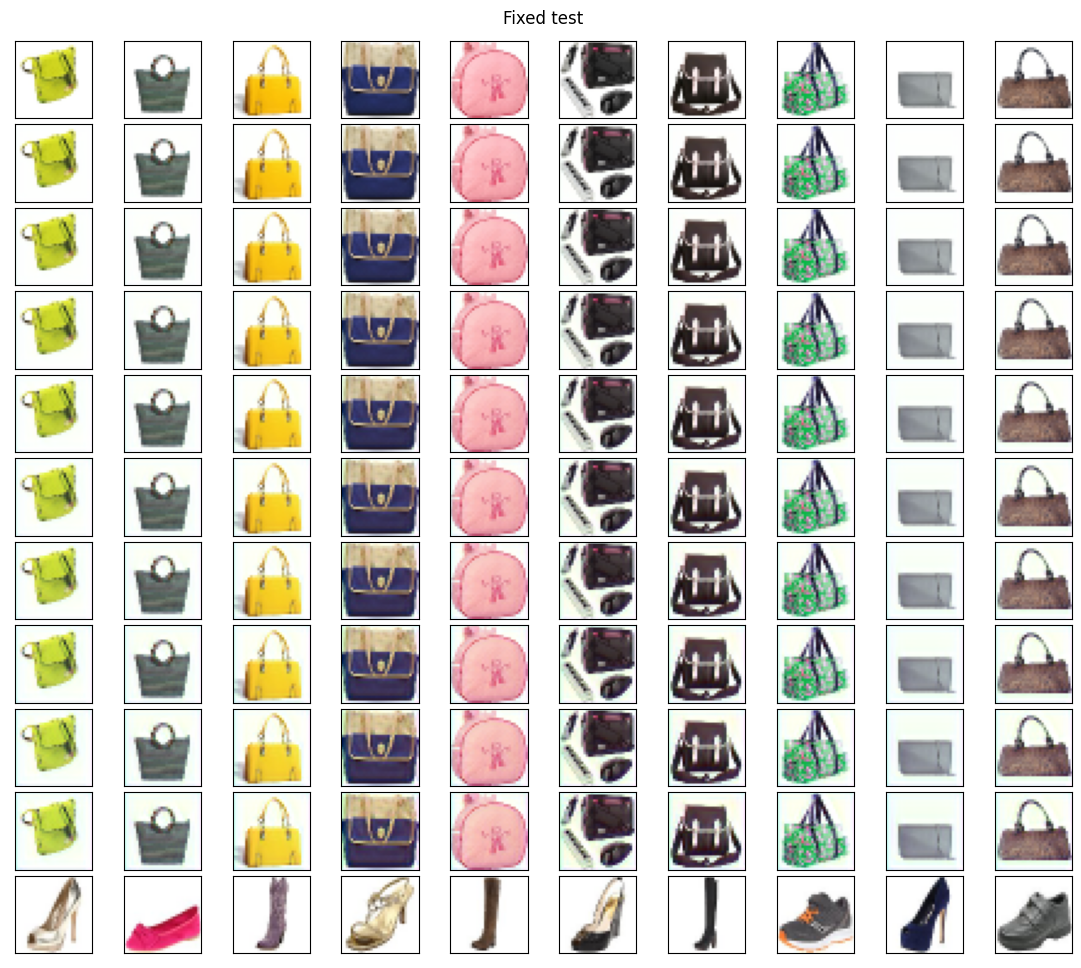

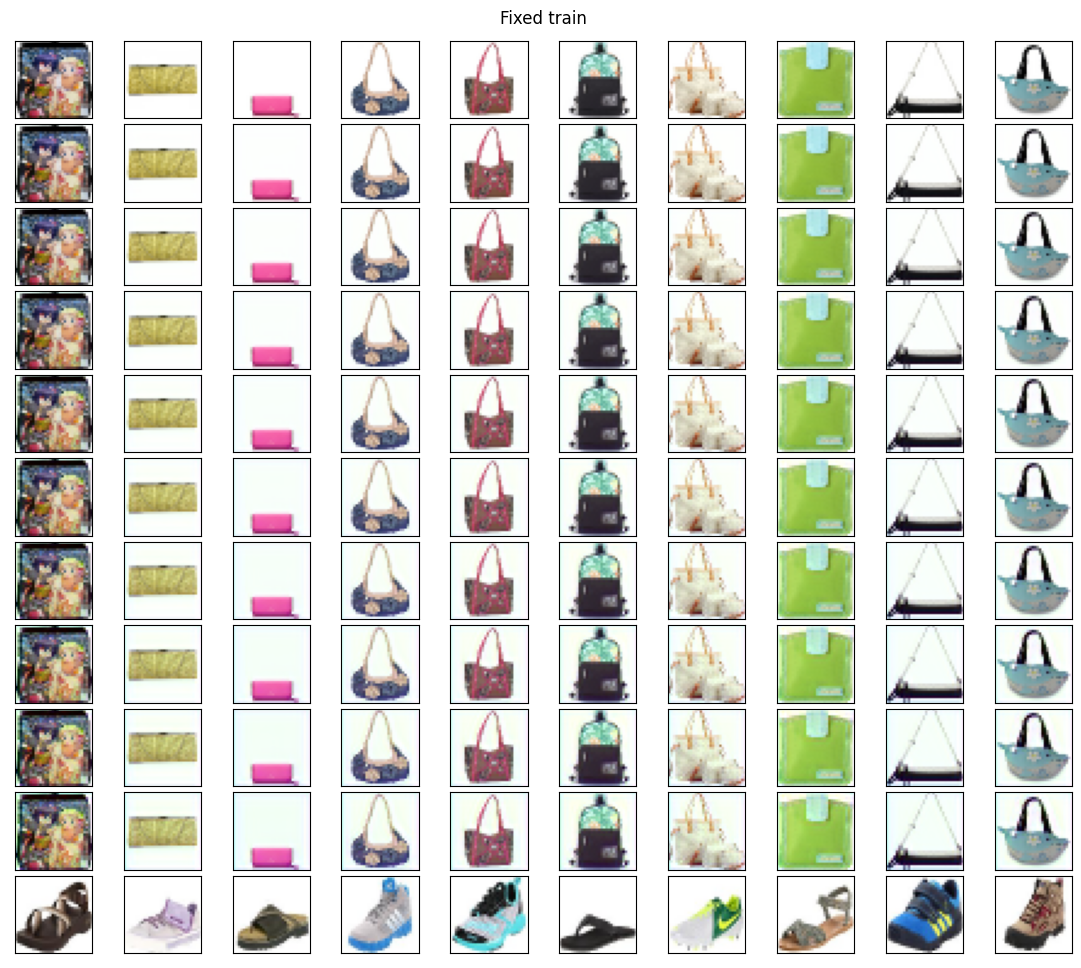

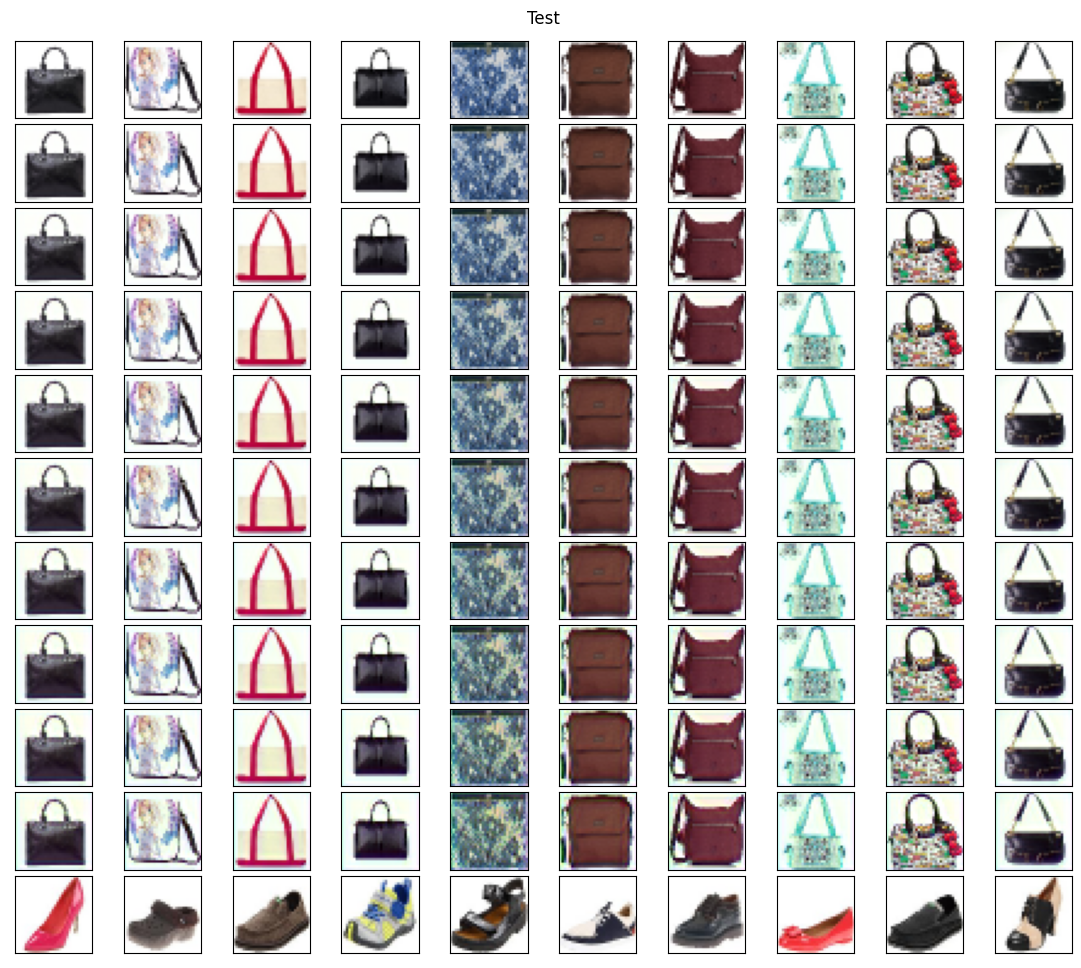

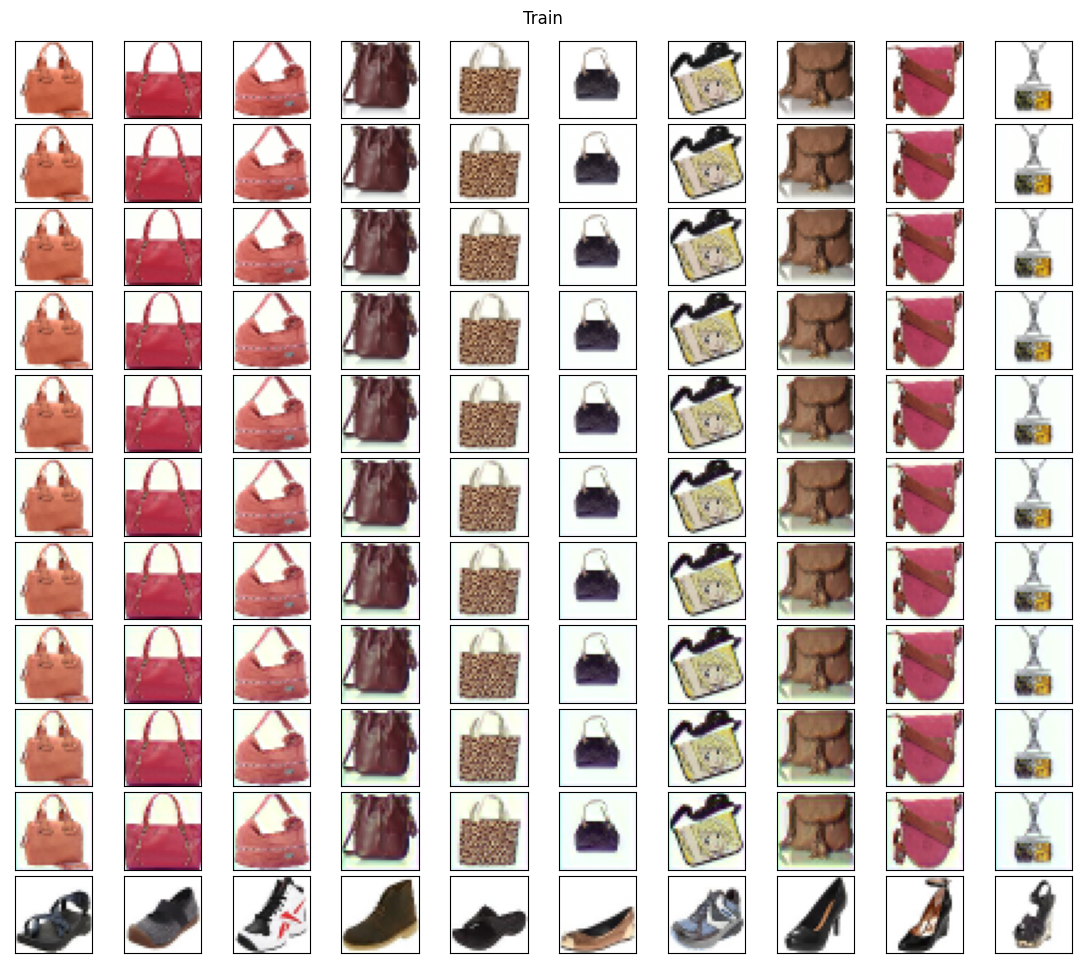

In [ ]:
train_loop(T,
           f,
           X_train_sampler.sample,
           Y_train_sampler.sample,
           BATCH_SIZE=BATCH_SIZE,
           T_ITERS=10,
           MAX_STEPS=100001,
           regularized=True)